# Loading The Data :

In [1]:
import os
os.getcwd()
os.chdir('/home/a4ankan/aMAZON fINAL WORK/amazon fine food')
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import datetime



# it connects my code with the sql database
con = sqlite3.connect('database.sqlite') 



#Writting a query; 'con' is the link
# Here, I am saying that 'slelct (*) from reviews which are not equal to 3'.
#Just take the reviews which are 1,2,4 or 5.



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) #filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3



# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return -1
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.sort_values('Time',inplace=True) 

print(filtered_data.shape) #The score coloumn becomesb positive / negative
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

(364173, 10)


69.25890143662969

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)



display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [5]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


 1    307061
-1     57110
Name: Score, dtype: int64

In [6]:
filtered_data[['Score','Text', 'Time']].head()

,Score,Text,Time
138706,1,this witty little book makes my son laugh at l...,939340800
138683,1,I can remember seeing the show when it aired o...,940809600
417839,1,Beetlejuice is a well written movie ..... ever...,944092800
417859,1,"A twist of rumplestiskin captured on film, sta...",944438400
212472,1,"A twist of rumplestiskin captured on film, sta...",944438400


In [7]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skating and snowmen in the winter; strong wind in March; birds and flowers in the spring; swimming and hot temperatures in the summer; and finally different holidays throughout the year. Such as Halloween in October, and Christmas in December.<br /><br />Sendak's simple three colored crayon-like drawings are a perfect addition to his educational and entertaining story.<br /><br />A great activity that you can do with this book is to have children draw their own illustrations for each month of the year.  Afterwards you can bind the pages together so the children can cre

In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'theirs', 'not', 'only', 'about', 'further', 'can', 'him', 'couldn', 'wouldn', "wouldn't", 'what', 'from', "that'll", 'own', 'some', 'itself', 'any', 'during', 'more', 'through', 'for', 'was', 'before', 'you', 'just', "you've", 'then', 'mustn', 'out', 'is', 'because', 'up', 'yours', 'between', 'mightn', 'here', 'herself', 'off', 'into', 'yourself', "don't", 'are', 'ain', 'down', 'but', 'now', 'how', 'who', 'same', 'd', 'm', 'these', 'will', 'isn', 'should', 'doesn', 'with', 'wasn', 'won', 'as', 'haven', 'ma', "didn't", 'over', 'didn', "you'll", "aren't", 'its', 'having', 'he', 'your', "she's", 'hers', 'needn', 'if', 'an', 'his', "isn't", 'has', 'which', 'hasn', 'under', 'being', 'ourselves', 'where', 'don', "mustn't", "needn't", 'we', 'be', 'me', 'them', 'nor', 'shouldn', 'myself', 'no', 'doing', 'himself', 'at', 'of', 'do', 'all', 'll', 'other', 'y', 'when', 'again', 't', 'they', 'have', 'why', "you're", 'her', 'hadn', "doesn't", "it's", 'am', 'this', 'whom', 'did', 'she', 'yourselve

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    

cleaning the "Summary" column too....
-----

In [10]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase


i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Summary'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [11]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [12]:
final['Summary']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['Summary']=final['Summary'].str.decode("utf-8")

In [13]:
final['New'] = final['Summary'] + final['CleanedText']

In [14]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,this witty little book makes my son laugh at l...,everi book educ,everi book educeveri book educ
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,mmmm chicken soup,Summary: A young boy describes the usefulness...,mmmm chicken soup,mmmm chicken soupmmmm chicken soup
138699,150517,0006641040,ABW4IC5G5G8B5,kevin clark,0,0,1,1291075200,good children,"Classic children's book, can't go wrong. I rea...",good children,good childrengood children
138680,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,1,1176336000,gem book,This is a wonderful little book. I loved it 40...,gem book,gem bookgem book
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup rice month,This is a fun way for children to learn their ...,chicken soup rice month,chicken soup rice monthchicken soup rice month


In [15]:

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [16]:
print(final.shape)

final.head(3)

(364171, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,this witty little book makes my son laugh at l...,everi book educ,everi book educeveri book educ
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,mmmm chicken soup,Summary: A young boy describes the usefulness...,mmmm chicken soup,mmmm chicken soupmmmm chicken soup
138699,150517,0006641040,ABW4IC5G5G8B5,kevin clark,0,0,1,1291075200,good children,"Classic children's book, can't go wrong. I rea...",good children,good childrengood children


# Time based Splitting :

In [17]:
final = final.sort_values('Time')

In [18]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,this witty little book makes my son laugh at l...,everi book educ,everi book educeveri book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole seri great way spend time child,I can remember seeing the show when it aired o...,whole seri great way spend time child,whole seri great way spend time childwhole ser...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,entertainingl funni,Beetlejuice is a well written movie ..... ever...,entertainingl funni,entertainingl funnientertainingl funni
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,modern day fairi tale,"A twist of rumplestiskin captured on film, sta...",modern day fairi tale,modern day fairi talemodern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,fantast,Beetlejuice is an excellent and funny movie. K...,fantast,fantastfantast


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import warnings
from sklearn import preprocessing
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

In [20]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import scikitplot as skplt

In [21]:
final = final[0 : 20000] # Sampling 20000k rows 
final = pd.DataFrame(final)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,this witty little book makes my son laugh at l...,everi book educ,everi book educeveri book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole seri great way spend time child,I can remember seeing the show when it aired o...,whole seri great way spend time child,whole seri great way spend time childwhole ser...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,entertainingl funni,Beetlejuice is a well written movie ..... ever...,entertainingl funni,entertainingl funnientertainingl funni
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,modern day fairi tale,"A twist of rumplestiskin captured on film, sta...",modern day fairi tale,modern day fairi talemodern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,fantast,Beetlejuice is an excellent and funny movie. K...,fantast,fantastfantast


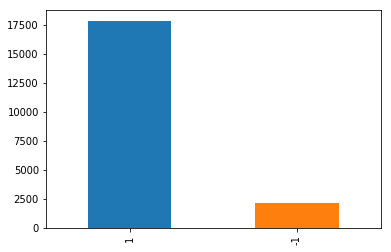

In [22]:
final['Score'].value_counts().plot(kind='bar')

In [23]:
X = final['New']
X.shape

(20000,)

In [24]:
Y = final['Score']
Y.head()

138706    1
138683    1
417839    1
346055    1
417838    1
Name: Score, dtype: int64

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (16000,)
Test Data Size:  (4000,)


# BoW:

In [26]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train) #
X_test_bow = count_vect.transform(X_test)#
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (16000, 14536)
the number of unique words  14536


In [27]:

X_train_bow = preprocessing.normalize(X_train_bow)

In [28]:

X_test_bow = preprocessing.normalize(X_test_bow)

In [29]:

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_bow):
    print(X_train_bow[train].shape, X_train_bow[cv].shape)


(1460, 14536) (1454, 14536)
(2914, 14536) (1454, 14536)
(4368, 14536) (1454, 14536)
(5822, 14536) (1454, 14536)
(7276, 14536) (1454, 14536)
(8730, 14536) (1454, 14536)
(10184, 14536) (1454, 14536)
(11638, 14536) (1454, 14536)
(13092, 14536) (1454, 14536)
(14546, 14536) (1454, 14536)


In [30]:
from sklearn.model_selection import cross_val_score
from datetime import datetime
from sklearn.metrics import roc_auc_score

<h2>Brute Force with Accuracy as metric:</h2>


The optimal number of neighbors is 3.


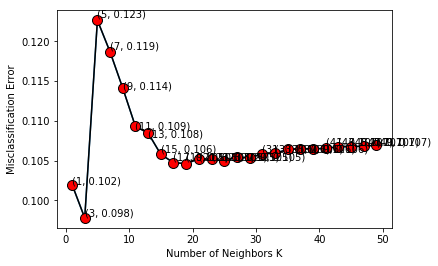

the misclassification error for each k value is :  [0.102 0.098 0.123 0.119 0.114 0.109 0.108 0.106 0.105 0.105 0.105 0.105
 0.105 0.105 0.105 0.106 0.106 0.106 0.106 0.106 0.107 0.107 0.107 0.107
 0.107]

------------------------------------------------------------------------
Time taken to run this cell :
 0:04:50.956856
------------------------------------------------------------------------


In [31]:
start = datetime.now()


myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs = -1)
    scores = cross_val_score(knn, X_train_bow, Y_train, cv = time_series, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 85.600%
Macro F1-Score on test set: 0.530
Micro F1-Score on test set: 0.856
Weighted F1-Score on test set: 0.836
roc_auc Score on test set: 0.527
Precision on test set: 0.896
Recall on test set: 0.948
Error : 14.400%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.20      0.11      0.14       436
           1       0.90      0.95      0.92      3564

   micro avg       0.86      0.86      0.86      4000
   macro avg       0.55      0.53      0.53      4000
weighted avg       0.82      0.86      0.84      4000

TPR is 0.9478114478114478
TNR is 0.10550458715596331
FPR is 0.8944954128440367
FNR is 0.05218855218855219


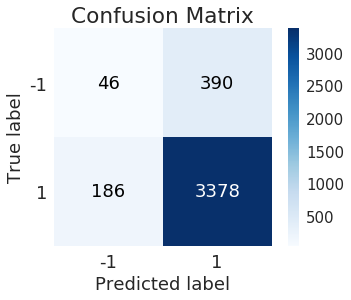

In [64]:
clf = KNeighborsClassifier(n_neighbors = 3 , algorithm = 'brute')    
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


<h3> Brute force with f-1 as metric</h3>


The optimal number of neighbors is 3.


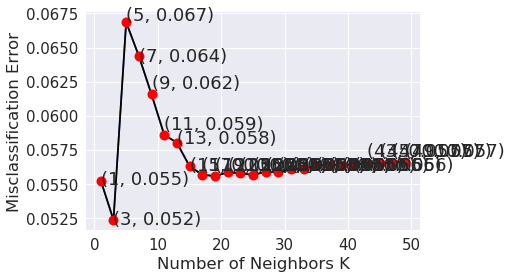

the misclassification error for each k value is :  [0.055 0.052 0.067 0.064 0.062 0.059 0.058 0.056 0.056 0.056 0.056 0.056
 0.056 0.056 0.056 0.056 0.056 0.056 0.056 0.056 0.056 0.057 0.057 0.057
 0.057]

------------------------------------------------------------------------
Time taken to run this cell :
 0:08:29.807825
------------------------------------------------------------------------


In [33]:



myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs = -1)
    scores = cross_val_score(knn, X_train_bow, Y_train, cv = time_series, scoring='f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 85.600%
Macro F1-Score on test set: 0.530
Micro F1-Score on test set: 0.856
Weighted F1-Score on test set: 0.836
roc_auc Score on test set: 0.527
Precision on test set: 0.896
Recall on test set: 0.948
Error : 14.400%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.20      0.11      0.14       436
           1       0.90      0.95      0.92      3564

   micro avg       0.86      0.86      0.86      4000
   macro avg       0.55      0.53      0.53      4000
weighted avg       0.82      0.86      0.84      4000

TPR is 0.9478114478114478
TNR is 0.10550458715596331
FPR is 0.8944954128440367
FNR is 0.05218855218855219


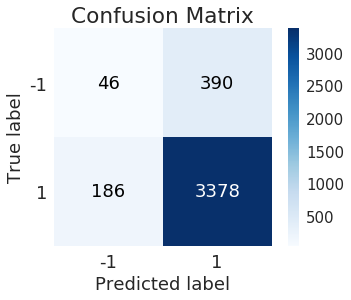

In [65]:
clf = KNeighborsClassifier(n_neighbors = 3 , algorithm = 'brute')    
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


<h3> Brute force with roc_auc as metric </h3>


The optimal number of neighbors is 49.


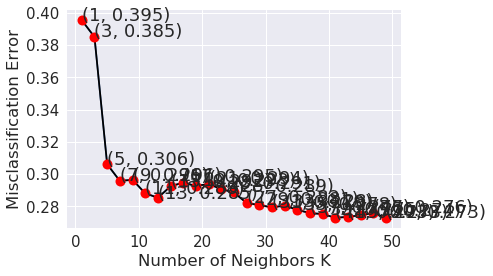

the misclassification error for each k value is :  [0.395 0.385 0.306 0.296 0.296 0.288 0.285 0.292 0.295 0.293 0.294 0.291
 0.289 0.282 0.281 0.279 0.28  0.278 0.276 0.275 0.273 0.273 0.274 0.276
 0.273]

------------------------------------------------------------------------
Time taken to run this cell :
 0:11:50.032403
------------------------------------------------------------------------


In [35]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs = -1)
    scores = cross_val_score(knn, X_train_bow, Y_train, cv = time_series, scoring='roc_auc')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 88.725%
Macro F1-Score on test set: 0.477
Micro F1-Score on test set: 0.887
Weighted F1-Score on test set: 0.839
roc_auc Score on test set: 0.501
Precision on test set: 0.891
Recall on test set: 0.995
Error : 11.275%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.14      0.01      0.01       436
           1       0.89      0.99      0.94      3564

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.52      0.50      0.48      4000
weighted avg       0.81      0.89      0.84      4000

TPR is 0.9949494949494949
TNR is 0.006880733944954129
FPR is 0.9931192660550459
FNR is 0.005050505050505051


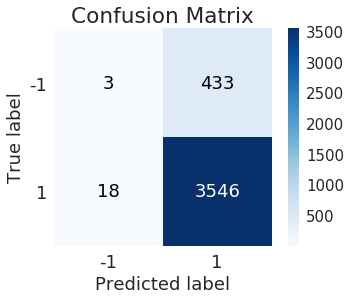

In [66]:
clf = KNeighborsClassifier(n_neighbors = 49 , algorithm = 'brute')    
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


---------------------------------------------------------------------------------------------

<h3> ***We can not pass a sparse matrix in a kd_tree algorithm. So, to make it dense we are using truncated SVD with 999 features*** </h3>

In [37]:
from sklearn.decomposition import TruncatedSVD

svd_bow = TruncatedSVD(n_components = 999)
X_train_bow = svd_bow.fit_transform(X_train_bow)
X_test_bow = svd_bow.transform(X_test_bow)

In [38]:
X_train_bow

array([[ 7.74081433e-02,  7.67069151e-02,  4.26891874e-01, ...,
         2.92860576e-03,  2.69162385e-03, -5.25459597e-04],
       [ 7.19703886e-03,  9.15877341e-03,  1.10867691e-02, ...,
        -4.81947885e-03, -3.05665221e-03, -2.60218053e-03],
       [ 3.85232098e-03,  3.84859258e-03,  1.18922099e-02, ...,
        -5.84169830e-03, -8.29715474e-03,  7.24594468e-03],
       ...,
       [ 2.70919071e-17,  1.29050243e-14,  3.02351685e-14, ...,
         6.01350189e-06,  3.16104208e-05, -1.96196931e-05],
       [ 2.38568458e-07,  6.12696358e-07,  3.13063094e-06, ...,
         2.46605864e-02, -9.00006071e-02, -5.13347667e-02],
       [ 1.01471550e-01,  1.96072386e-02, -2.68714666e-02, ...,
         1.60165985e-02, -5.94794024e-03, -8.12109541e-04]])

In [39]:
X_train_bow = X_train_bow.argsort()[:, ::-1]
X_train_bow

array([[  2, 119, 138, ..., 136, 144,   3],
       [ 16,  14,  17, ...,  19,  33,  20],
       [ 48, 625, 629, ..., 621,  68,  72],
       ...,
       [458, 460, 459, ..., 464, 462, 463],
       [932, 881, 902, ..., 992, 952, 997],
       [  7, 488, 477, ..., 487, 479,   4]])

In [40]:
X_test_bow = X_test_bow.argsort()[:, ::-1]
X_test_bow

array([[  2,   3,   1, ..., 268,   5, 259],
       [  1,  17,  21, ...,   2,  16, 121],
       [  2,  81,  83, ...,   4,  32,   3],
       ...,
       [  7,   0, 139, ...,  13, 141,   4],
       [219, 218, 362, ..., 213, 214, 397],
       [ 28,  72,  31, ...,  71, 267,  30]])

<h3> Kd_tree with accuracy as metric: </h3>


The optimal number of neighbors is 41.


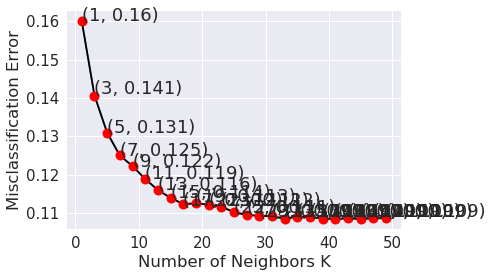

the misclassification error for each k value is :  [0.16  0.141 0.131 0.125 0.122 0.119 0.116 0.114 0.112 0.113 0.112 0.112
 0.11  0.11  0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109]

------------------------------------------------------------------------
Time taken to run this cell :
 1:22:40.593412
------------------------------------------------------------------------


In [41]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_bow, Y_train, cv = time_series, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 88.550%
Macro F1-Score on test set: 0.482
Micro F1-Score on test set: 0.885
Weighted F1-Score on test set: 0.840
roc_auc Score on test set: 0.503
Precision on test set: 0.892
Recall on test set: 0.992
Error : 11.450%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.18      0.01      0.03       436
           1       0.89      0.99      0.94      3564

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.53      0.50      0.48      4000
weighted avg       0.81      0.89      0.84      4000

TPR is 0.9921436588103255
TNR is 0.013761467889908258
FPR is 0.9862385321100917
FNR is 0.007856341189674524


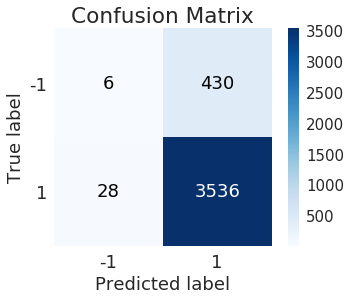

In [67]:
clf = KNeighborsClassifier(n_neighbors = 41 , algorithm = 'kd_tree')    
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


<h3> kd_tree with f1 as metric </h3>


The optimal number of neighbors is 45.


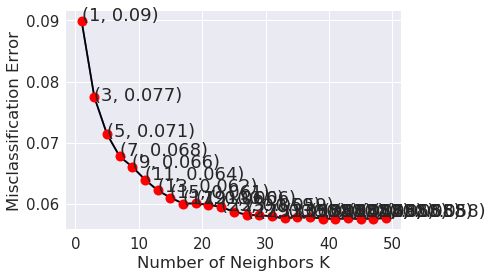

the misclassification error for each k value is :  [0.09  0.077 0.071 0.068 0.066 0.064 0.062 0.061 0.06  0.06  0.06  0.059
 0.059 0.058 0.058 0.058 0.058 0.058 0.058 0.058 0.058 0.058 0.058 0.058
 0.058]

------------------------------------------------------------------------
Time taken to run this cell :
 2:40:27.864558
------------------------------------------------------------------------


In [43]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_bow, Y_train, cv = time_series, scoring='f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 88.700%
Macro F1-Score on test set: 0.479
Micro F1-Score on test set: 0.887
Weighted F1-Score on test set: 0.839
roc_auc Score on test set: 0.502
Precision on test set: 0.891
Recall on test set: 0.994
Error : 11.300%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.17      0.01      0.02       436
           1       0.89      0.99      0.94      3564

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.53      0.50      0.48      4000
weighted avg       0.81      0.89      0.84      4000

TPR is 0.9943883277216611
TNR is 0.009174311926605505
FPR is 0.9908256880733946
FNR is 0.005611672278338945


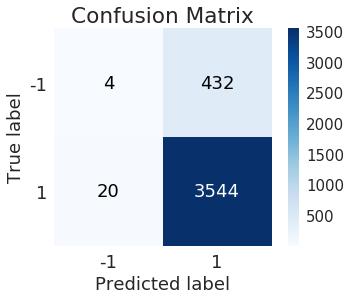

In [68]:
clf = KNeighborsClassifier(n_neighbors = 45 , algorithm = 'kd_tree')    
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


<h3> kd_tree with roc_auc as metric</h3>


The optimal number of neighbors is 19.


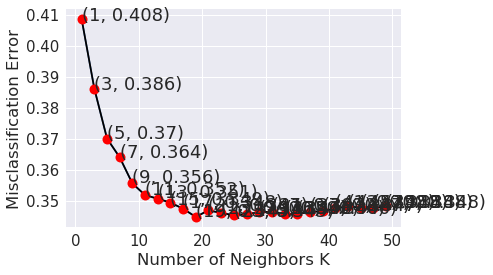

the misclassification error for each k value is :  [0.408 0.386 0.37  0.364 0.356 0.352 0.351 0.349 0.348 0.345 0.347 0.346
 0.345 0.346 0.346 0.347 0.346 0.346 0.347 0.347 0.348 0.348 0.348 0.348
 0.348]

------------------------------------------------------------------------
Time taken to run this cell :
 3:51:03.968876
------------------------------------------------------------------------


In [45]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_bow, Y_train, cv = time_series, scoring='roc_auc')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 87.875%
Macro F1-Score on test set: 0.493
Micro F1-Score on test set: 0.879
Weighted F1-Score on test set: 0.839
roc_auc Score on test set: 0.506
Precision on test set: 0.892
Recall on test set: 0.983
Error : 12.125%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.17      0.03      0.05       436
           1       0.89      0.98      0.94      3564

   micro avg       0.88      0.88      0.88      4000
   macro avg       0.53      0.51      0.49      4000
weighted avg       0.81      0.88      0.84      4000

TPR is 0.9826038159371493
TNR is 0.02981651376146789
FPR is 0.9701834862385321
FNR is 0.01739618406285073


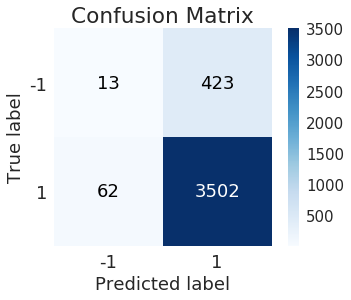

In [69]:
clf = KNeighborsClassifier(n_neighbors = 19 , algorithm = 'kd_tree')    
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


<h1> Summary for Bag of words </h1>

In [87]:
from prettytable import PrettyTable

y = PrettyTable()

y.field_names = ["S.R","METRIC", "K", "Micro f-1", "Weighted f-1", 'roc_auc']

y.add_row([(1),"Accuracy", 41, 0.885, 0.840, 0.503])
y.add_row([(2),"F-1", 45, 0.887, 0.839, 0.502])
y.add_row([(3),"roc_auc", 19, 0.879, 0.839, 0.506])




print(y.get_string(title = "Summary Table for Bag of Words(kd_tree ALgorithm)"))



x = PrettyTable()

x.field_names = ["S.R","METRIC", "K", "Micro f-1", "Weighted f-1", 'roc_auc']

x.add_row([(1),"Accuracx", 3, 0.856, 0.836, 0.527])
x.add_row([(2),"F-1", "--do--","--do--","--do--","--do--"])
x.add_row([(3),"roc_auc", 49, 0.887, 0.837, 0.501])




print(x.get_string(title = "Summary Table for Bag of Words(Brute ALgorithm)"))



+----------------------------------------------------------+
|    Summary Table for Bag of Words(kd_tree ALgorithm)     |
+-----+----------+----+-----------+--------------+---------+
| S.R |  METRIC  | K  | Micro f-1 | Weighted f-1 | roc_auc |
+-----+----------+----+-----------+--------------+---------+
|  1  | Accuracy | 41 |   0.885   |     0.84     |  0.503  |
|  2  |   F-1    | 45 |   0.887   |    0.839     |  0.502  |
|  3  | roc_auc  | 19 |   0.879   |    0.839     |  0.506  |
+-----+----------+----+-----------+--------------+---------+
+--------------------------------------------------------------+
|       Summary Table for Bag of Words(Brute ALgorithm)        |
+-----+----------+--------+-----------+--------------+---------+
| S.R |  METRIC  |   K    | Micro f-1 | Weighted f-1 | roc_auc |
+-----+----------+--------+-----------+--------------+---------+
|  1  | Accuracx |   3    |   0.856   |    0.836     |  0.527  |
|  2  |   F-1    | --do-- |   --do--  |    --do--    |  --do-

# TF_IDF:

In [47]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train_tf = tf_idf_vect.fit_transform(X_train.values)
X_test_tf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_tf))
print("the shape of out text TFIDF vectorizer ",X_train_tf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (16000, 52255)
the number of unique words including both unigrams and bigrams  52255


In [48]:

X_train_tf = preprocessing.normalize(X_train_tf)

In [49]:

X_test_tf = preprocessing.normalize(X_test_tf)

In [50]:

tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_tf):
    print(X_train_tf[train].shape, X_train_tf[cv].shape)


(1460, 52255) (1454, 52255)
(2914, 52255) (1454, 52255)
(4368, 52255) (1454, 52255)
(5822, 52255) (1454, 52255)
(7276, 52255) (1454, 52255)
(8730, 52255) (1454, 52255)
(10184, 52255) (1454, 52255)
(11638, 52255) (1454, 52255)
(13092, 52255) (1454, 52255)
(14546, 52255) (1454, 52255)


<h2> Brute Force: </h2>

<h3> Metric = Accuracy </h3>


The optimal number of neighbors is 1.


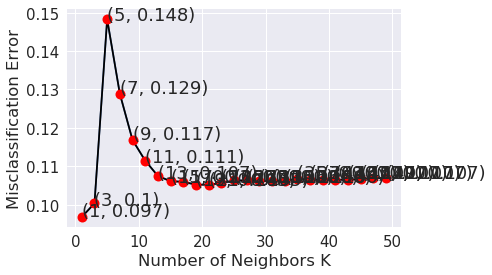

the misclassification error for each k value is :  [0.097 0.1   0.148 0.129 0.117 0.111 0.107 0.106 0.106 0.105 0.105 0.106
 0.106 0.106 0.106 0.106 0.106 0.107 0.107 0.107 0.107 0.107 0.107 0.107
 0.107]

------------------------------------------------------------------------
Time taken to run this cell :
 0:05:03.720533
------------------------------------------------------------------------


In [51]:
start = datetime.now()


myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs = -1)
    scores = cross_val_score(knn, X_train_tf, Y_train, cv = time_series, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h3> Metric = f1 </h3>


The optimal number of neighbors is 1.


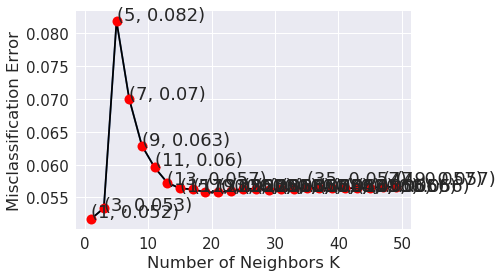

the misclassification error for each k value is :  [0.052 0.053 0.082 0.07  0.063 0.06  0.057 0.056 0.056 0.056 0.056 0.056
 0.056 0.056 0.056 0.056 0.056 0.057 0.056 0.056 0.056 0.056 0.056 0.057
 0.057]

------------------------------------------------------------------------
Time taken to run this cell :
 0:03:08.246790
------------------------------------------------------------------------


In [52]:
start = datetime.now()


myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs = -1)
    scores = cross_val_score(knn, X_train_tf, Y_train, cv = time_series, scoring='f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 82.175%
Macro F1-Score on test set: 0.579
Micro F1-Score on test set: 0.822
Weighted F1-Score on test set: 0.829
roc_auc Score on test set: 0.587
Precision on test set: 0.910
Recall on test set: 0.887
Error : 17.825%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.24      0.29      0.26       436
           1       0.91      0.89      0.90      3564

   micro avg       0.82      0.82      0.82      4000
   macro avg       0.57      0.59      0.58      4000
weighted avg       0.84      0.82      0.83      4000

TPR is 0.8872053872053872
TNR is 0.286697247706422
FPR is 0.713302752293578
FNR is 0.1127946127946128


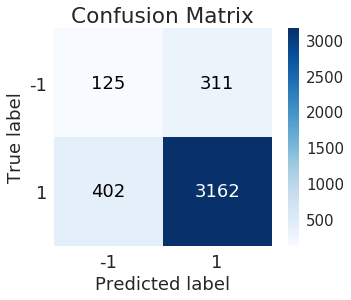

In [70]:
clf = KNeighborsClassifier(n_neighbors = 1 , algorithm = 'brute')    
clf.fit(X_train_tf, Y_train)
Y_pred = clf.predict(X_test_tf)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


<h3> Metric = roc_auc </h3>


The optimal number of neighbors is 49.


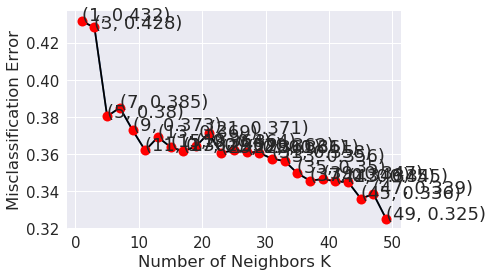

the misclassification error for each k value is :  [0.432 0.428 0.38  0.385 0.373 0.362 0.369 0.364 0.362 0.364 0.371 0.361
 0.362 0.361 0.361 0.358 0.356 0.35  0.346 0.347 0.345 0.345 0.336 0.339
 0.325]

------------------------------------------------------------------------
Time taken to run this cell :
 0:03:02.257181
------------------------------------------------------------------------


In [54]:
start = datetime.now()


myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='brute', n_jobs = -1)
    scores = cross_val_score(knn, X_train_tf, Y_train, cv = time_series, scoring='roc_auc')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 89.050%
Macro F1-Score on test set: 0.503
Micro F1-Score on test set: 0.890
Weighted F1-Score on test set: 0.846
roc_auc Score on test set: 0.515
Precision on test set: 0.894
Recall on test set: 0.995
Error : 10.950%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.47      0.03      0.06       436
           1       0.89      1.00      0.94      3564

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.68      0.51      0.50      4000
weighted avg       0.85      0.89      0.85      4000

TPR is 0.995230078563412
TNR is 0.034403669724770644
FPR is 0.9655963302752294
FNR is 0.004769921436588103


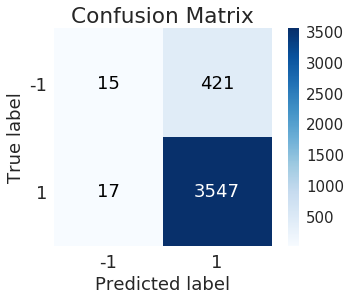

In [71]:
clf = KNeighborsClassifier(n_neighbors = 49 , algorithm = 'brute')    
clf.fit(X_train_tf, Y_train)
Y_pred = clf.predict(X_test_tf)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


# Kd_tree:

In [56]:
svd_tf = TruncatedSVD(n_components = 249)##Here i tried 1000,750,500 but i was getting memory errror
X_train_tf = svd_tf.fit_transform(X_train_tf)
X_test_tf = svd_tf.transform(X_test_tf)





In [57]:
X_train_tf = X_train_tf.argsort()[:, ::-1]
X_train_tf

array([[203, 196,  19, ...,  17, 215, 192],
       [ 33,  40,  56, ...,  52,  41,  34],
       [110, 109, 108, ..., 142,  78, 113],
       ...,
       [248, 218, 247, ..., 234, 229, 246],
       [225, 237, 205, ..., 247, 238, 248],
       [  2, 108,  75, ...,  16, 110, 111]])

In [58]:
X_test_tf = X_test_tf.argsort()[:, ::-1]
X_test_tf

array([[ 13,  16,   9, ..., 246,  17,  14],
       [  8,  16,  14, ...,  23,  21,   9],
       [ 19, 131, 167, ..., 133, 132,  17],
       ...,
       [  2,  75,  31, ...,  16,  77,  26],
       [239, 247, 228, ..., 245, 248, 230],
       [ 64,  58,  72, ...,  77,  63,  78]])

<h3> Metric = Accuracy </h3>


The optimal number of neighbors is 39.


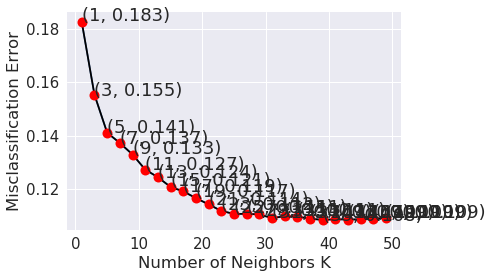

the misclassification error for each k value is :  [0.183 0.155 0.141 0.137 0.133 0.127 0.124 0.121 0.119 0.117 0.114 0.112
 0.111 0.111 0.11  0.109 0.11  0.11  0.109 0.108 0.109 0.109 0.109 0.109
 0.109]

------------------------------------------------------------------------
Time taken to run this cell :
 0:21:24.249276
------------------------------------------------------------------------


In [59]:
start = datetime.now()


myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='kd_tree', n_jobs = -1)
    scores = cross_val_score(knn, X_train_tf, Y_train, cv = time_series, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 88.875%
Macro F1-Score on test set: 0.512
Micro F1-Score on test set: 0.889
Weighted F1-Score on test set: 0.847
roc_auc Score on test set: 0.519
Precision on test set: 0.895
Recall on test set: 0.992
Error : 11.125%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.41      0.05      0.08       436
           1       0.89      0.99      0.94      3564

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.65      0.52      0.51      4000
weighted avg       0.84      0.89      0.85      4000

TPR is 0.9918630751964085
TNR is 0.045871559633027525
FPR is 0.9541284403669725
FNR is 0.00813692480359147


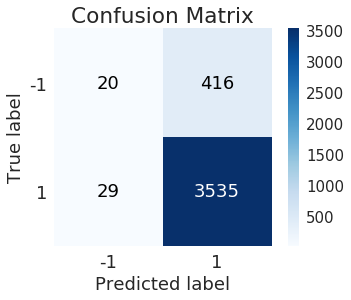

In [72]:
clf = KNeighborsClassifier(n_neighbors = 39 , algorithm = "kd_tree")    
clf.fit(X_train_tf, Y_train)
Y_pred = clf.predict(X_test_tf)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


<h3> Metric = f1 </h3>


The optimal number of neighbors is 39.


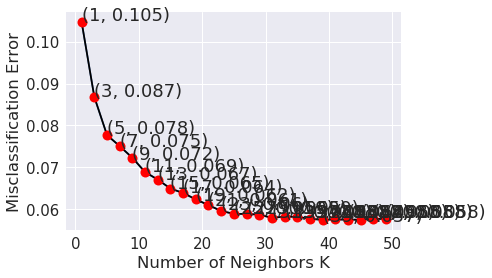

the misclassification error for each k value is :  [0.105 0.087 0.078 0.075 0.072 0.069 0.067 0.065 0.064 0.062 0.061 0.06
 0.059 0.059 0.059 0.058 0.058 0.058 0.058 0.057 0.058 0.058 0.058 0.058
 0.058]

------------------------------------------------------------------------
Time taken to run this cell :
 0:21:50.679631
------------------------------------------------------------------------


In [61]:
start = datetime.now()


myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm= 'kd_tree', n_jobs = -1)
    scores = cross_val_score(knn, X_train_tf, Y_train, cv = time_series, scoring= 'f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

<h3> Metric = roc_auc </h3>


The optimal number of neighbors is 37.


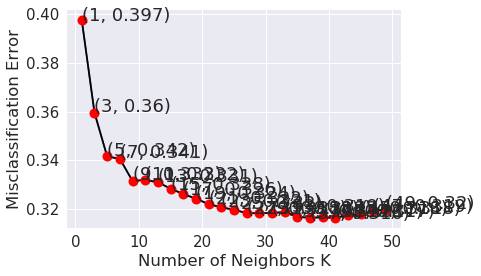

the misclassification error for each k value is :  [0.397 0.36  0.342 0.341 0.332 0.332 0.331 0.328 0.326 0.324 0.322 0.321
 0.32  0.318 0.318 0.318 0.319 0.317 0.316 0.317 0.317 0.318 0.318 0.319
 0.32 ]

------------------------------------------------------------------------
Time taken to run this cell :
 0:13:47.984307
------------------------------------------------------------------------


In [62]:
start = datetime.now()


myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

time_series = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='kd_tree', n_jobs = -1)
    scores = cross_val_score(knn, X_train_tf, Y_train, cv = time_series, scoring='roc_auc')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='black',marker='o',
             markerfacecolor='red', markersize=10)
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))



print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 88.900%
Macro F1-Score on test set: 0.517
Micro F1-Score on test set: 0.889
Weighted F1-Score on test set: 0.849
roc_auc Score on test set: 0.522
Precision on test set: 0.895
Recall on test set: 0.991
Error : 11.100%
Precision recall report :
               precision    recall  f1-score   support

          -1       0.43      0.05      0.09       436
           1       0.90      0.99      0.94      3564

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.66      0.52      0.52      4000
weighted avg       0.84      0.89      0.85      4000

TPR is 0.9913019079685746
TNR is 0.052752293577981654
FPR is 0.9472477064220184
FNR is 0.008698092031425365


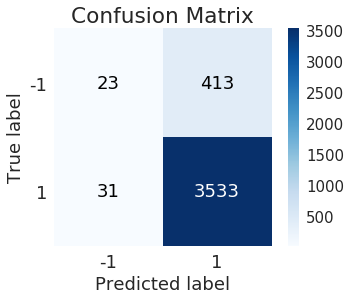

In [73]:
clf = KNeighborsClassifier(n_neighbors = 37 , algorithm = "kd_tree")    
clf.fit(X_train_tf, Y_train)
Y_pred = clf.predict(X_test_tf)
sns.set(font_scale=1.5)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred)))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)


<h1>Summary Table for tf-idf:</h1>

In [79]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["S.R","METRIC", "K", "Micro f-1", "Weighted f-1", 'roc_auc']

x.add_row([(1),"Accuracy", 39, 0.889, 0.547, 0.519])
x.add_row([(2),"F-1", "--do--","--do--","--do--","--do--"])
x.add_row([(3),"roc_auc", 37, 0.889, 0.549, 0.522])




print(x.get_string(title = "Summary Table for Tf-Idf(kd_tree)"))


from prettytable import PrettyTable

y = PrettyTable()

y.field_names = ["S.R","METRIC", "K", "Micro f-1", "Weighted f-1", 'roc_auc']

y.add_row([(1),"Accuracy", 39, 0.882, 0.529, 0.587])
y.add_row([(2),"F-1", "--do--","--do--","--do--","--do--"])
y.add_row([(3),"roc_auc", 49, 0.890, 0.846, 0.515])




print(y.get_string(title = "Summary Table for Tf-Idf(Brute Force ALgorithm)"))





+--------------------------------------------------------------+
|              Summary Table for Tf-Idf(kd_tree)               |
+-----+----------+--------+-----------+--------------+---------+
| S.R |  METRIC  |   K    | Micro f-1 | Weighted f-1 | roc_auc |
+-----+----------+--------+-----------+--------------+---------+
|  1  | Accuracy |   39   |   0.889   |    0.547     |  0.519  |
|  2  |   F-1    | --do-- |   --do--  |    --do--    |  --do-- |
|  3  | roc_auc  |   37   |   0.889   |    0.549     |  0.522  |
+-----+----------+--------+-----------+--------------+---------+
+--------------------------------------------------------------+
|       Summary Table for Tf-Idf(Brute Force ALgorithm)        |
+-----+----------+--------+-----------+--------------+---------+
| S.R |  METRIC  |   K    | Micro f-1 | Weighted f-1 | roc_auc |
+-----+----------+--------+-----------+--------------+---------+
|  1  | Accuracy |   39   |   0.882   |    0.529     |  0.587  |
|  2  |   F-1    | --do--